# Traffic Sign Recognition with Tensorflow


This notebook is the first part of a tutorial to build a deep learning model for traffic sign recognition. The goal is to build a model that can detect and classify traffic signs in a video stream taken from a moving car. 


## First Objective: Traffic Sign Classification

I'll start with a simple goal: classifiction. Given an image of a traffic sign, our model should be able to tell it's type (e.g. Stop sign, speed limit, yield sign, ...etc.). We'll work with images that are properly cropped such that the traffic sign takes most of the image.


For this project, I'm using Pythong 3.5, Tensorflow 0.11, Numpy, Sci-kit Image, and Matplotlib. All pretty standard tools in machine learning. For convenience, I've created a docker image that contains the most common deep learning tools in one place here: https://hub.docker.com/r/waleedka/modern-deep-learning/ . You can run it with this command:

```
docker run -it -p 8888:8888 -p 6006:6006 -v ~/traffic:/traffic waleedka/modern-deep-learning
```

Note that I have the files of this project in the ~/traffic directory, and I'm it to /traffic directory in the Docker container. Modify this if you're using a different directory.

First step, let's import the needed libraries and get that out of the way.

In [ ]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Allow image embeding in notebook
%matplotlib inline

## Trainging Dataset

We're using the Belgian Traffic Sign Dataset. Go to http://btsd.ethz.ch/shareddata/ and download the training and test data. There is a lot of datasets on that page, but you only need the two files listed under **BelgiumTS for Classification (cropped images)**":	
* BelgiumTSC_Training (171.3MBytes)
* BelgiumTSC_Testing (76.5MBytes)

After downloading and expanding the files, your directory structure should look something like this:

```
/traffic/datasets/BelgiumTS/Training/
/traffic/datasets/BelgiumTS/Testing/
```

Each of the two directories above has 62 sub-directories named sequentially from 00000 to 00062. The directory name represents the code (or label) and the images inside the directory are examples of that label. 

## Parse and Load the Training Data

The **Training** directory contains sub-directories with sequental numerical names from 00000 to 00061. The name of the directory represents the labels from 0 to 61, and the images in each directory represent the traffic signs that belong to that label. The images are saved in the not-so-common .ppm format, but luckily, this format is supported in the skimage library.

In [2]:
def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels


# Load training and testing datasets.
ROOT_PATH = "./"
train_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Training")
test_data_dir = os.path.join(ROOT_PATH, "datasets/BelgiumTS/Testing")

images_train, labels_train = load_data(train_data_dir)
images_test, labels_test = load_data(test_data_dir)

Here we're loading two lists:
* **images** a list of images, each image is represted by a numpy array.
* **labels** a list of labels. Integers with values between 0 and 61.


It's not usually a good idea to load the whole dataset into memory, but this dataset is small and we're trying to keep the code simple, so it's okay for now. We'll improve it in the next part. For larger datasets, we'd want to have a separate thread loading chunks of data in the background and feeding them to the training thread. 

## Explore the Dataset

How many images and labels do we have?

In [3]:
print("Unique Labels: {0}\nTotal Images: {1}".format(len(set(labels_train)), len(images_train)))

Unique Labels: 62
Total Images: 4575


Display the first image of each label.

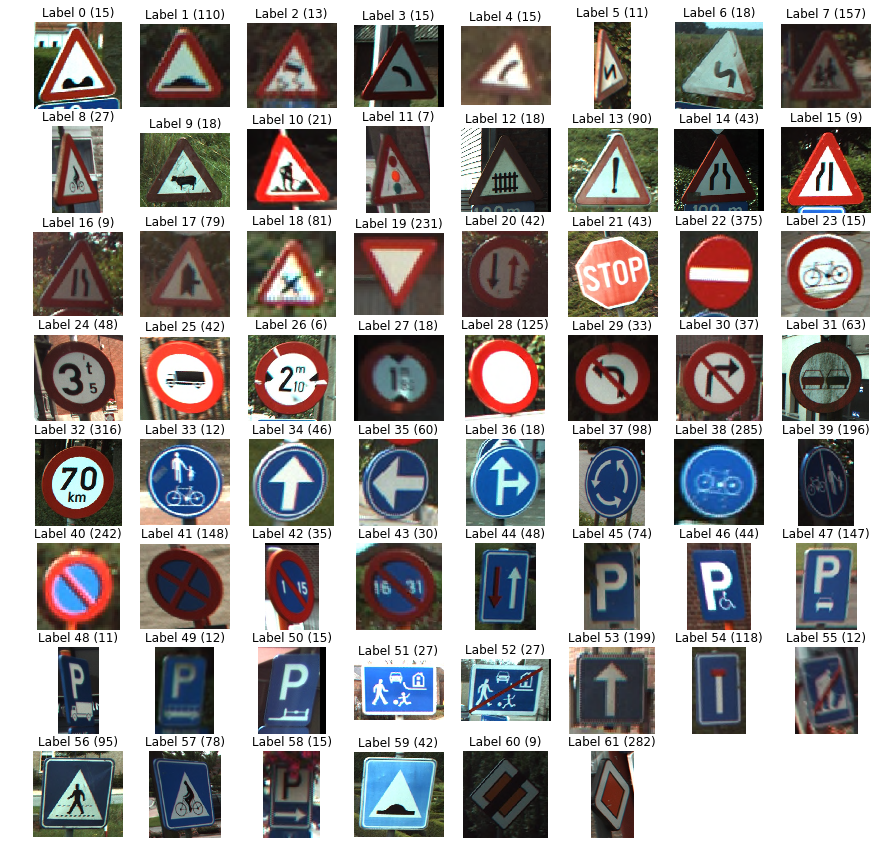

In [4]:
def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

display_images_and_labels(images_train, labels_train)

That looks great! The traffic signs occupy most of the area of each image, which is going to make our job easier: we don't have to look for the sign in the image. And we have a variety of angles and lighting conditions, which will help our model generalize. 

However, although the images are square-ish, they're not all the same size. They have different aspect ratios. Our simple neural network takes a fixed-size input, so we have a bit of pre-processing to do. We'll get to that soon, but first let's pick a label and see more of it's images. Let's pick label 32:

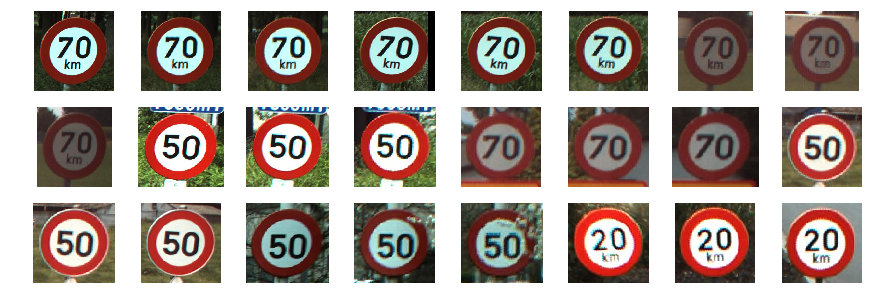

In [5]:
def display_label_images(images, label):
    """Display images of a specific label."""
    limit = 24  # show a max of 24 images
    plt.figure(figsize=(15, 5))
    i = 1

    start = labels_train.index(label)
    end = start + labels_train.count(label)
    for image in images[start:end][:limit]:
        plt.subplot(3, 8, i)  # 3 rows, 8 per row
        plt.axis('off')
        i += 1
        plt.imshow(image)
    plt.show()

display_label_images(images_train, 32)

Interesting! It looks like our dataset considers all speeding limit signs to be of the same class regardless of the numbers on them. That's fine, as long as we know about it beforehand and don't let it confuse us later when the output doesn't match our expectation. 

I'll leave exploring other labels as an exercise for you, edit the code above and check other labels. Make sure to check Labels 26 and 27. They also have numbers in a red circle, so our model will have to get really good to differentiate between these 3 classes.

## Handling images of different sizes?

Most neural networks expect a fixed-size input, and our network is no exception. But as we've seen above, our images are not all the same size. A common approach is to crop and pad the images to a selected apect ratio, but then we have to make sure that we don't cut-off parts of the traffic signs in the process. That seems like it might require manual work! Let's do a simpler solution instead (a hack really): We'll just resize the images to a fixed size and ignore the distortions caused by the different aspect ratios. A person can easily recognize a traffic sign even if it's compressed or stretched a bit, so we hope that our model can as well. 

And while we're at it, let's make the images smaller. The larger the input data, the larger the model, and the slower it is to train. In the early stages of development we want fast training to avoid long waits between iterations while we change the code rapidly. 

What are the sizes of our image anyway?

In [6]:
for image in images_train[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (141, 142, 3), min: 0, max: 255
shape: (120, 123, 3), min: 0, max: 255
shape: (105, 107, 3), min: 0, max: 255
shape: (94, 105, 3), min: 7, max: 255
shape: (128, 139, 3), min: 0, max: 255


The sizes seem to hover around 128x128. If we resize them to, say, 32x32, we'll have reduced the data and the model size by a factor of 16. And 32x32 is probably still big enough to recognize the signs, so let's go with that. 

I'm also in the habit of frequently printing the min() and max() values. It's a simple way to verify the range of your data and catch bugs early.

In [7]:
# Resize images
images32_train = [skimage.transform.resize(image, (32, 32), mode='reflect')
                for image in images_train]
images32_test = [skimage.transform.resize(image, (32, 32), mode='reflect')
                for image in images_test]

The 32x32 images are not as sharp but still recognizable. Note that the display above shows the images larger than their real size because the matplotlib library tries to fit them to the grid size. Let's print the sizes of a few images to verify that we got it right.

In [8]:
for image in images32_train[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (32, 32, 3), min: 0.0073912377450982, max: 1.0
shape: (32, 32, 3), min: 0.003576899509804572, max: 1.0
shape: (32, 32, 3), min: 0.0015567555147058805, max: 1.0
shape: (32, 32, 3), min: 0.056774662990195915, max: 0.969267003676469
shape: (32, 32, 3), min: 0.026654411764708223, max: 0.9895220588235292


The sizes are correct. But check the min and max values! They now range from 0 to 1.0, which is different from the 0-255 range we saw above. The resizing function did that transformation for us. Normalizing values to the range 0.0-1.0 is very common so we'll keep it. But remember to multiply by 255 if you later want to convert the images back to the normal 0-255 range.

# Minimum Viable Model

In [9]:
labels_train_arr = np.array(labels_train)
images_train_arr = np.reshape(np.array(images32_train), (4575, 3072))
labels_test_arr = np.array(labels_test)
images_test_arr = np.reshape(np.array(images32_test), (2520, 3072))

print("train labels: ", labels_train_arr.shape, "\ntrain images: ", images_train_arr.shape)
print("test labels: ", labels_test_arr.shape, "\ntest images: ", images_test_arr.shape)

train labels:  (4575,) 
train images:  (4575, 3072)
test labels:  (2520,) 
test images:  (2520, 3072)


In [10]:
learning_rate = 0.001
num_steps = 300
batch_size = 16

# Network Parameters
num_input = 32*32*3 # data input (img shape: 32*32*3)
num_classes = 62 # total classes (0-61 digits)
dropout = 0.75 # Dropout, probability to keep units

def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 32, 32, 3])

        # Convolution Layer with 32 filters and a kernel size of 5
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

        # Convolution Layer with 64 filters and a kernel size of 3
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
        # Max Pooling (down-sampling) with strides of 2 and kernel size of 2
        conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

        
        

    return out

In [ ]:

NHIDDEN_MDN = 50
STDEV_MDN   = 0.1
KMIX    = 15 # NUMBER OF MIXTURES
NOUT    = KMIX * 3 # PI / MU / STD

x = tf.placeholder(dtype=tf.float32, shape=[None,1], name="x")
y = tf.placeholder(dtype=tf.float32, shape=[None,1], name="y")

Wmdn = {
    "l1": tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32)),
    "l2": tf.Variable(tf.random_normal([NHIDDEN,NOUT], stddev=STDEV, dtype=tf.float32))
}
bmdn = {
    "l1": tf.Variable(tf.random_normal([1,NHIDDEN], stddev=STDEV, dtype=tf.float32)),
    "l2": tf.Variable(tf.random_uniform([1,NOUT], minval=-10, maxval=10, dtype=tf.float32))
}
def multiple_density_network(_x, _W, _b):
    sig_gain = 1
    _l1  = tf.nn.tanh(tf.matmul(_x, _W['l1']) + _b['l1'])
    _out = tf.matmul(_l1, _W['l2']) + _b['l2']
    # CONVERT OUTPUT
    _out_pi_hat, _out_sigma_hat, _out_mu = tf.split(_out, 3, 1)
    _out_pi_hat = tf.exp(_out_pi_hat - tf.reduce_max(_out_pi_hat, 1, keep_dims=True))
    _nor_pi = tf.reciprocal(tf.reduce_sum(_out_pi_hat, 1, keep_dims=True))
    _out_pi = tf.multiply(_nor_pi, _out_pi_hat)
    _out_sigma = sig_gain*tf.sigmoid(_out_sigma_hat)
    return _out_pi, _out_sigma, _out_mu
out_pi, out_sigma, out_mu = mdn(x, Wmdn, bmdn)
print ("MIXTURE DENSITY NETOWRK READY")

In [11]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False,
                            is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True,
                           is_training=False)
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)

    pred_probas = tf.nn.softmax(logits_test)

    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions={'class': pred_classes,
                     'prob': tf.nn.softmax(logits_test)})

        # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op,
                                  global_step=tf.train.get_global_step())

    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)

    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
        mode=mode,
        predictions={'class': pred_classes,
                     'prob': tf.nn.softmax(logits_test)},
        loss=loss_op,
        train_op=train_op,
        eval_metric_ops={'accuracy': acc_op})

    return estim_specs


In [12]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {}


In [13]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': images_train_arr.astype(np.float32)}, y=labels_train_arr,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into /tmp/tmpuvu0l5bl/model.ckpt.
INFO:tensorflow:loss = 4.12322, step = 1
INFO:tensorflow:global_step/sec: 22.343
INFO:tensorflow:loss = 2.12889, step = 101 (4.476 sec)
INFO:tensorflow:global_step/sec: 23.6651
INFO:tensorflow:loss = 1.14801, step = 201 (4.224 sec)
INFO:tensorflow:Saving checkpoints for 300 into /tmp/tmpuvu0l5bl/model.ckpt.
INFO:tensorflow:Loss for final step: 0.591801.


In [14]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': images_test_arr.astype(np.float32)}, y=labels_test_arr,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
e = model.evaluate(input_fn)
print(e)
print("Testing Accuracy:", e['accuracy'])

INFO:tensorflow:Starting evaluation at 2017-10-12-18:09:21
INFO:tensorflow:Restoring parameters from /tmp/tmpuvu0l5bl/model.ckpt-300
INFO:tensorflow:Finished evaluation at 2017-10-12-18:09:24
INFO:tensorflow:Saving dict for global step 300: accuracy = 0.812302, global_step = 300, loss = 0.926067
{'loss': 0.92606711, 'accuracy': 0.81230158, 'global_step': 300}
Testing Accuracy: 0.812302


## Using the Model

The session object contains the values of all the variables in our model (i.e. the weights). 

In [15]:
# Pick 10 random images
sample_indexes = random.sample(range(len(images_test_arr)), 10)
sample_images = [images_test_arr[i] for i in sample_indexes]
sample_labels = [labels_test[i] for i in sample_indexes]

# Predict single images

input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': np.array(sample_images).astype(np.float32)}, shuffle=False)

predicted = model.predict(input_fn)
predicted = list(predicted)
predicted_class = [item['class'] for item in predicted]
predicted_prob = [item['prob'].round(decimals=3) for item in predicted]
print(predicted_prob)
predicted_prob = np.amax(predicted_prob, axis=1)

print(sample_labels)
print(predicted_class)
print(predicted_prob)

INFO:tensorflow:Restoring parameters from /tmp/tmpuvu0l5bl/model.ckpt-300
[array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.002     ,  0.        ,  0.        ,  0.002     ,  0.004     ,
        0.001     ,  0.001     ,  0.        ,  0.001     ,  0.008     ,
        0.002     ,  0.001     ,  0.96899998,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.001     ,  0.001     ,  0.002     ,  0.002     ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ], dtype=float32), array([ 0.,

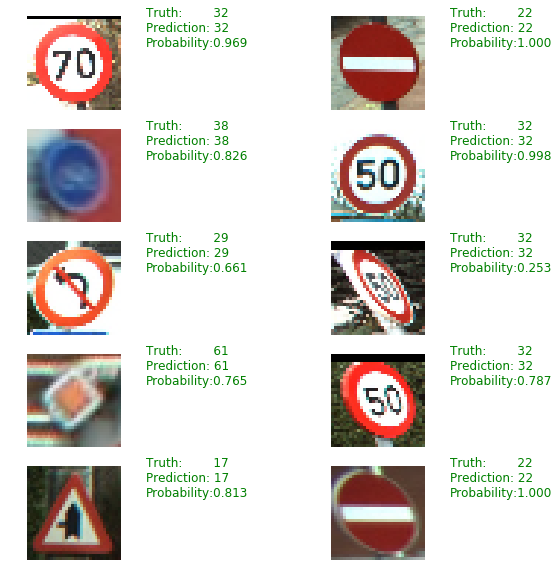

In [16]:
# Display the predictions and the ground truth visually.
fig = plt.figure(figsize=(10, 10))
for i in range(len(sample_images)):
    truth = sample_labels[i]
    prediction = predicted_class[i]
    probability = predicted_prob[i]
    plt.subplot(5, 2,1+i)
    plt.axis('off')
    color='green' if truth == prediction else 'red'
    plt.text(40, 10, "Truth:        {0}\nPrediction: {1}\nProbability:{2:.3f}".format(truth, prediction, probability), 
             fontsize=12, color=color)
    plt.imshow(np.reshape(sample_images[i], [32, 32, 3]))


## Evaluation

It's fun to visualize the results, but we need a more precise way to measure the accuracy of our model. Also, it's important to test it on images that it hasn't seen. And that's where the validation data set comes into play.

In [18]:
# Close the session. This will destroy the trained model.
session.close()